In [13]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np

We are implementing the quantum error correction code on five qubits, aka $[[5,1,3]]$

We want to make it so we can encode 2 qubits into their logical states, $\ket{0_L}$ and $\ket{1_L}$.
Here we encode $\ket{0_L}$.

Notice that since we encode the values in this step, we want to be able to decode them later. This is a simple matter of saving the inverse of this quantum circuit, and applying it later when we wish to decode.

In [14]:
def setup_qubits(qc,qreg,x): #sets up the qubits so they have their logical zero state

    if x == 1:
        qc.x(qreg[0])

    qc.z(qreg[0])
    qc.h(qreg[1:])

    for j in range(4):
        qc.cx(qreg[::-1][j],qreg[0])

    qc.cz(qreg[0],qreg[4])
    qc.cz(qreg[0],qreg[1])
    qc.cz(qreg[1],qreg[2])
    qc.cz(qreg[2],qreg[3])
    qc.cz(qreg[3],qreg[4])

    inv = qc.inverse()
    return qc,inv
qreg = QuantumRegister(5,name = 'qreg')
qc = QuantumCircuit(qreg,name='[5,1,3]')
[qc,inv] = setup_qubits(qc,qreg,0)
display(qc.draw())
Statevector(qc).draw('latex')

┌───┐┌───┐┌───┐┌───┐┌───┐               
qreg_0: ┤ Z ├┤ X ├┤ X ├┤ X ├┤ X ├─■──■──────────
        ├───┤└─┬─┘└─┬─┘└─┬─┘└─┬─┘ │  │          
qreg_1: ┤ H ├──┼────┼────┼────■───┼──■──■───────
        ├───┤  │    │    │        │     │       
qreg_2: ┤ H ├──┼────┼────■────────┼─────■──■────
        ├───┤  │    │             │        │    
qreg_3: ┤ H ├──┼────■─────────────┼────────■──■─
        ├───┤  │                  │           │ 
qreg_4: ┤ H ├──■──────────────────■───────────■─
        └───┘

<IPython.core.display.Latex object>

Next we want to add in a random Pauli error (with probability $p$) to each qubit. So each qubit can have one erroneous gate (of X, Y, or Z gate) added, or it could have no erroneous gate at all.

In [15]:
def add_random_Pauli_error(qc,qreg,p):
    rnd = np.random.random() #choose whether or not an error happened
    if rnd < 3*p:
        g_error = np.random.choice(['x','y','z']) #choose what error
        if g_error == 'x': #apply those errors
            qc.x(qreg[0])
        elif g_error == 'y':
            qc.y(qreg[0])
        elif g_error == 'z':
            qc.z(qreg[0])
    return qc


Now we will test to find which error we have and where that error is. We do this by using the generators of the stabilizer group for five qubits, represented here as rows in the matrix:

$$G = \begin{bmatrix*}
XZZXI\\
IXZZX\\
XIXZZ\\
ZXIXZ
\end{bmatrix*}$$

and encoding them into $4$ ancilla markers, which will then be measured into syndromes to determine which qubits have which errors. If all gates perform as desired with no errors, then all syndromes will be equal to $0$.

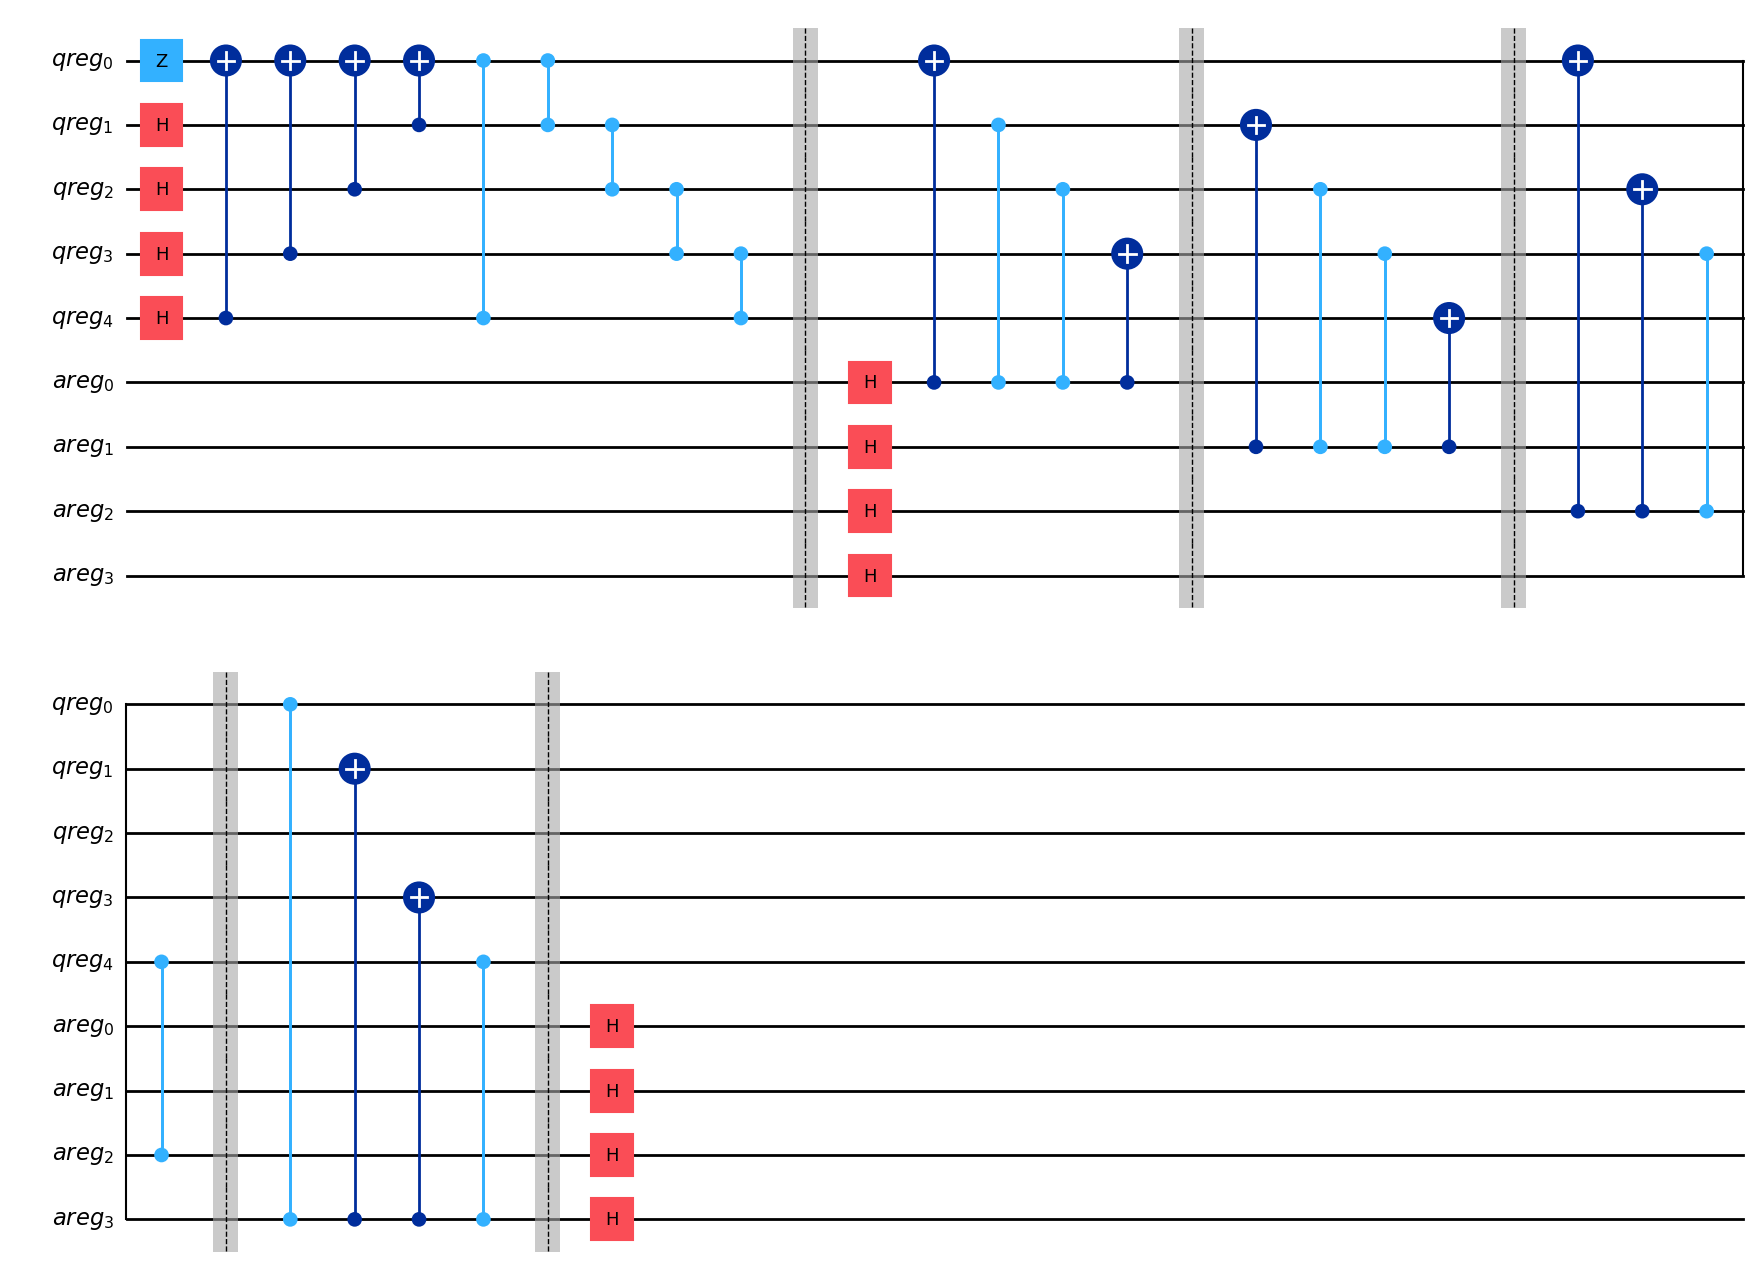

In [16]:
def adding_ancillas(qc,qreg,areg): #performs tests aligning with the basis errors so the ancillas can see who has what error
    qc.h(areg)

    qc.cx(areg[0],qreg[0])
    qc.cz(areg[0],qreg[1])
    qc.cz(areg[0],qreg[2])
    qc.cx(areg[0],qreg[3])
    qc.barrier()

    qc.cx(areg[1],qreg[1])
    qc.cz(areg[1],qreg[2])
    qc.cz(areg[1],qreg[3])
    qc.cx(areg[1],qreg[4])
    qc.barrier()

    qc.cx(areg[2],qreg[0])
    qc.cx(areg[2],qreg[2])
    qc.cz(areg[2],qreg[3])
    qc.cz(areg[2],qreg[4])
    qc.barrier()

    qc.cz(areg[3],qreg[0])
    qc.cx(areg[3],qreg[1])
    qc.cx(areg[3],qreg[3])
    qc.cz(areg[3],qreg[4])
    qc.barrier()

    qc.h(areg)

    return qc

areg=AncillaRegister(4,name='areg') #add in the ancillas that test for the errors that'll go to syndrome land
qc.add_register(areg)
qc.barrier()
qc = adding_ancillas(qc,qreg,areg)
display(qc.draw('mpl'))

#add in the syndromes and measure the ancilla bits to them
syns=ClassicalRegister(4,name='syns')
qc.add_register(syns) 

for j in range(4):
    qc.measure(areg[j],syns[j])

To determine what combination of syndromes corresponds to what outcome, we encode the generators of the stabilizer group into a dictionary that will determine what syndrome combination means what error.

We consider 

$$G^T = \begin{bmatrix*}
XIXZ\\
ZXIX\\
ZZXI\\
XZZX\\
IXZZ
\end{bmatrix*}$$

where the rows correspond to the $5$ qubits.

Consider the first qubit. If this qubit was victim to an erroneous gate, the syndrome associated with this outcome will correspond to the first row of the matrix $G^T$: which is $[X, I, X, Z]$. Say the erroneous gate was an $X$ gate. Then the $X, I, X$ of the row commute, but the $Z$ gate's operation was tampered with, and so the syndrome corresponding to this situation is $[0,0,0,1]$. Say that the erroneous gate was a $Z$ gate. Then the $I$ and $Z$ gates of that row do not change the measurement, but both $X$ gates' operations were tampered with, and so the syndrome corresponding to this situation is $[1,0,1,0]$. For the last case of a $Y$ gate, since $Y=iXZ$, then this is the case of both an erroneous $X$ and $Z$ gate, and so the syndrome in this case is simply $[1,0,1,1]$, the syndromes where both $X$ and $Z$ happen on the first qubit. Similarly, there is a unique syndrome for all of the possible cases on all of the possible qubits.

We encode this error-finding formula into a dictionary that takes a given syndrome and returns the error-stricked qubit, as well as the erroneous gate it was subjected to.

In [17]:
def make_error_dict(error_basis): #makes a dictionary that will say which syndrome combo means what issue with which qubit

    error_basis_T = np.array(error_basis).transpose()
    error_dict=dict()

    for j1 in range(len(error_basis_T)):
        for gate_error in ['x','y','z']:
            syn_string = [0]*len(error_basis)
            for j2 in range(len(error_basis_T[0])):
                if (error_basis_T[j1][j2] not in [gate_error,'i']):
                    syn_string[j2] = 1
            error_dict[tuple(syn_string)] = [gate_error,j1]
    return error_dict

error_basis=[['x','z','z','x','i'],
             ['i','x','z','z','x'],
             ['x','i','x','z','z'],
             ['z','x','i','x','z']]
make_error_dict(error_basis)


{(0, 0, 0, 1): ['x', 0],
 (1, 0, 1, 1): ['y', 0],
 (1, 0, 1, 0): ['z', 0],
 (1, 0, 0, 0): ['x', 1],
 (1, 1, 0, 1): ['y', 1],
 (0, 1, 0, 1): ['z', 1],
 (1, 1, 0, 0): ['x', 2],
 (1, 1, 1, 0): ['y', 2],
 (0, 0, 1, 0): ['z', 2],
 (0, 1, 1, 0): ['x', 3],
 (1, 1, 1, 1): ['y', 3],
 (1, 0, 0, 1): ['z', 3],
 (0, 0, 1, 1): ['x', 4],
 (0, 1, 1, 1): ['y', 4],
 (0, 1, 0, 0): ['z', 4]}

Penultimately, we correct the errors. By examining the syndromes and the error dictionary, we can uniquely determine what error occurred on what qubit. We correct these errors by applying the same gate again.

In [18]:
def error_correction(qc,qreg,syns,error_dict):
    for key in error_dict.keys():

        with qc.if_test((syns[0],key[0])):
            with qc.if_test((syns[1],key[1])):
                with qc.if_test((syns[2],key[2])):
                    with qc.if_test((syns[3],key[3])):
                        dict_entry=error_dict[key]
                        if dict_entry[0]=='x':
                            qc.x(qreg[dict_entry[1]])
                        elif dict_entry[0]=='y':
                            qc.y(qreg[dict_entry[1]])
                        elif dict_entry[0]=='z':
                            qc.z(qreg[dict_entry[1]])
    return qc

Lastly, we apply the aforementioned decoding circuit from the first step. Then we can test if we have successfully corrected the errors by measuring the qubits to a classical register.

In [19]:
qc.compose(inv,inplace=True)
meas = ClassicalRegister(5,name = 'meas')
qc.add_register(meas)

for j in range(5):
    qc.measure(qreg[j],meas[j])

simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1000)
counts = job.result().get_counts()
counts

{'00000 0000': 1000}

Since we have a successful code here, we will apply it to the case where we have two qubits encoded and run thusly. This will necessitate five qubits to run the $[[5,1,3]]$ code for the first qubit, and another five qubits to run another copy of the $[[5,1,3]]$ code for the second qubit.

We initialize this code with can test how it works for multiple values of $p$, where $p$ is the probability of a qubit being affected by a random Pauli error.

In [20]:
def error_correction_circuit_on_2_qubits(x,p):

    qreg1 = QuantumRegister(5,name = 'qreg1')
    qreg2 = QuantumRegister(5,name = 'qreg2')
    qc = QuantumCircuit(qreg1,qreg2,name='2x[[5,1,3]]')

    [qc,inv1] = setup_qubits(qc,qreg1,x[0])
    [qc,inv2] = setup_qubits(qc,qreg2,x[1])

    qc = add_random_Pauli_error(qc,qreg1,p)
    qc = add_random_Pauli_error(qc,qreg2,p)
    qc.barrier()
    
    areg1 = AncillaRegister(4,name='areg1')
    areg2 = AncillaRegister(4,name='areg2')
    qc.add_register(areg1); qc.add_register(areg2)
    qc = adding_ancillas(qc,qreg1,areg1)
    qc = adding_ancillas(qc,qreg2,areg2)
    qc.barrier()

    syns1=ClassicalRegister(4,name='syns1')
    syns2=ClassicalRegister(4,name='syns2')
    qc.add_register(syns1); qc.add_register(syns2) #add in the syndromes and measure to them

    for j in range(4):
        qc.measure(areg1[j],syns1[j])
        qc.measure(areg2[j],syns2[j])

    error_basis=[['x','z','z','x','i'], #make the basis for the possible errors here
                ['i','x','z','z','x'],
                ['x','i','x','z','z'],
                ['z','x','i','x','z']]
    
    error_dict = make_error_dict(error_basis) #make the dictionary that says which errors mean what syndrome combo

    qc = error_correction(qc,qreg1,syns1,error_dict) #correct those errors
    qc = error_correction(qc,qreg2,syns2,error_dict)

    qc.compose(inv2,inplace=True) #decode the circuit

    #measure to make sure we successfully corrected the errors
    meas1 = ClassicalRegister(5,name = 'meas1') 
    meas2 = ClassicalRegister(5,name = 'meas2') 
    qc.add_register(meas1); qc.add_register(meas2)

    for j in range(5):
        qc.measure(qreg1[j],meas1[j])
        qc.measure(qreg2[j],meas2[j])
    return qc
qc = error_correction_circuit_on_2_qubits([0,1],0.5)


In [21]:
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1000)
counts = job.result().get_counts()
counts


{'00000 00000 1101 0101': 1000}

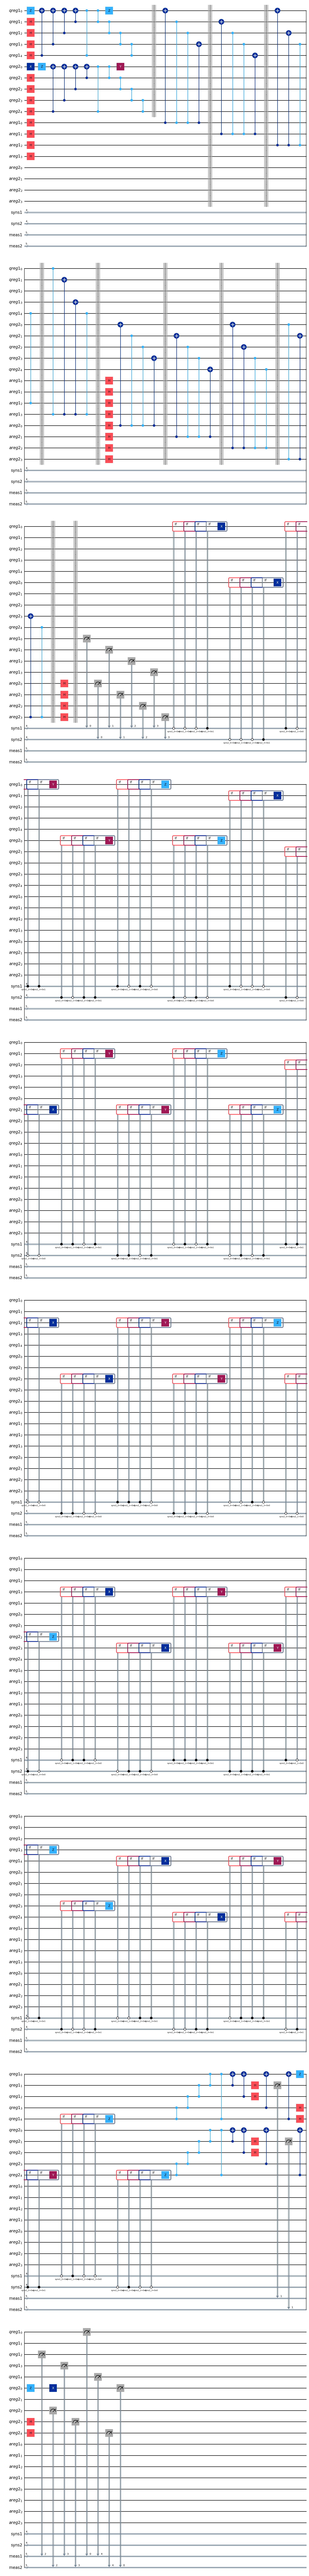

In [22]:
display(qc.draw('mpl'))